In [21]:
import requests
import json
from dateutil.relativedelta import relativedelta
import time
from datetime import datetime, timedelta

API_KEY = "c3Xc1gpJQBUMVcHMT4ibDIt26LdfTCRzJq1BRRMd"
NASA_APOD_URL = "https://api.nasa.gov/planetary/apod"

class ApodFetcher:
    def __init__(self, api_key, output_file="apod_2022_2023_archive.json"):
        self.api_key = api_key
        self.output_file = output_file

    def get_apod_info(self, target_date):
        try:
            params = {"api_key": self.api_key, "date": target_date}
            response = requests.get(NASA_APOD_URL, params=params)
            response.raise_for_status()
            apod_data = response.json()
            return {
                "date": apod_data["date"],
                "title": apod_data["title"],
                "image_link": apod_data["url"],
                "details": apod_data["explanation"],
                "media_type": apod_data["media_type"],
            }
        except requests.exceptions.RequestException as err:
            print(f"Could not get data for {target_date}: {err}")
            return None

    def download_apod_data_range(self, start_date, end_date):
        """
        Download APOD data for a range of dates and append to a JSON file without corrupting existing data.
        """
        try:
            file_dwnld = []
            try:
                with open(self.output_file, "r") as f:
                    existing_data = f.read().strip()
                    if existing_data:
                        file_dwnld = json.loads(existing_data)
            except FileNotFoundError:
                print(f"File '{self.output_file}' not found. Creating a new one.")
            except json.JSONDecodeError:
                print(f"File '{self.output_file}' contains invalid JSON. Starting fresh.")
            current_date = datetime.strptime(start_date, "%Y-%m-%d")
            finish_date = datetime.strptime(end_date, "%Y-%m-%d")

            while current_date <= finish_date:
                date_string = current_date.strftime("%Y-%m-%d")
                print(f"Getting APOD info for {date_string}...")
                apod_details = self.get_apod_info(date_string)

                if apod_details:
                    file_dwnld.append(apod_details)

                time.sleep(1)
                current_date += timedelta(days=1)
            with open(self.output_file, "w") as f:
                json.dump(file_dwnld, f, indent=4)
            print(f"Data successfully saved to '{self.output_file}'.")

        except Exception as e:
            print(f"An error occurred when processing the file: {e}")


def run_apod_collector():
    start_period = "2022-07-01"
    end_period = "2023-02-15"
    archive_file = "apod_2022_2023_archive.json"

    print("Beginning APOD collection process")
    apod_fetcher = ApodFetcher(api_key=API_KEY, output_file=archive_file)
    apod_fetcher.download_apod_data_range(start_period, end_period)
    print(f"APOD data collection complete. Outputs are written to {archive_file}.")

if __name__ == "__main__":
    run_apod_collector()


Beginning APOD collection process
Getting APOD info for 2022-07-01...
Getting APOD info for 2022-07-02...
Getting APOD info for 2022-07-03...
Getting APOD info for 2022-07-04...
Getting APOD info for 2022-07-05...
Getting APOD info for 2022-07-06...
Getting APOD info for 2022-07-07...
Getting APOD info for 2022-07-08...
Getting APOD info for 2022-07-09...
Getting APOD info for 2022-07-10...
Getting APOD info for 2022-07-11...
Getting APOD info for 2022-07-12...
Getting APOD info for 2022-07-13...
Getting APOD info for 2022-07-14...
Getting APOD info for 2022-07-15...
Getting APOD info for 2022-07-16...
Getting APOD info for 2022-07-17...
Getting APOD info for 2022-07-18...
Getting APOD info for 2022-07-19...
Getting APOD info for 2022-07-20...
Getting APOD info for 2022-07-21...
Getting APOD info for 2022-07-22...
Getting APOD info for 2022-07-23...
Getting APOD info for 2022-07-24...
Getting APOD info for 2022-07-25...
Getting APOD info for 2022-07-26...
Getting APOD info for 2022-07-

In [22]:

import json
import csv
import os

class ApodDataProcessor:
    """
    A class to handle APOD data operations such as reading, analyzing, and writing to CSV.
    """

    def __init__(self, json_file, csv_file):
        self.json_file = json_file
        self.csv_file = csv_file

    def read_apod_data(self):
        """
        Reads the JSON file and returns its content as a list of dictionaries.
        Handles FileNotFoundError, PermissionError, and empty files gracefully.
        """
        try:
            with open(self.json_file, "r") as file:
                data = json.load(file)
                if not data:
                    print("Error: The JSON file is empty.")
                    return []
                return data
        except FileNotFoundError:
            print(f"Error: File '{self.json_file}' not found.")
            return []
        except PermissionError:
            print(f"Error: Permission denied while trying to read '{self.json_file}'.")
            return []
        except json.JSONDecodeError:
            print(f"Error: File '{self.json_file}' is not a valid JSON.")
            return []

    def analyze_apod_media(self, data):
        """
        Analyzes APOD data to count media types and find the longest explanation.
        """
        image_count = 0
        video_count = 0
        longest_explanation = {"date": None, "title": None, "length": 0}

        for entry in data:
            media_type = entry.get("media_type", "unknown")
            if media_type == "image":
                image_count += 1
            elif media_type == "video":
                video_count += 1

            explanation = entry.get("details", "")
            if len(explanation) > longest_explanation["length"]:
                longest_explanation.update({
                    "date": entry.get("date"),
                    "title": entry.get("title"),
                    "length": len(explanation),
                })

        print(f"Total images: {image_count}, Total videos: {video_count}")
        print(f"Longest explanation: {longest_explanation['length']} characters on {longest_explanation['date']} ({longest_explanation['title']})")

    def write_apod_to_csv(self, data):
        """
        Extracts specific fields and writes them to a CSV file. Appends if the file exists.
        """
        try:
            file_exists = os.path.isfile(self.csv_file)
            with open(self.csv_file, "a", newline="") as csvfile:
                writer = csv.writer(csvfile)
                if not file_exists:
                    writer.writerow(["Date", "Title", "Media Type", "URL"])  # Write header if new file

                for entry in data:
                    writer.writerow([
                        entry.get("date", "N/A"),
                        entry.get("title", "N/A"),
                        entry.get("media_type", "N/A"),
                        entry.get("image_link", "N/A"),
                    ])
            print(f"Data successfully written to '{self.csv_file}'.")
        except PermissionError:
            print(f"Error: Permission denied while trying to write to '{self.csv_file}'.")

def main():
    # Specify input JSON file and output CSV file
    json_file = "apod_2022_2023_archive.json"
    csv_file = "apod_summary.csv"

    # Instantiate the processor
    processor = ApodDataProcessor(json_file, csv_file)

    # Read JSON data
    apod_data = processor.read_apod_data()

    if apod_data:
        # Analyze APOD media data
        processor.analyze_apod_media(apod_data)

        # Write data to CSV
        processor.write_apod_to_csv(apod_data)

if __name__ == "__main__":
    main()


Total images: 226, Total videos: 12
Longest explanation: 1443 characters on 2022-07-16 (Tycho and Clavius at Dawn)
Data successfully written to 'apod_summary.csv'.


In [23]:
import numpy as np

def create_array():
    np.random.seed(42)
    array = np.random.randint(10, 101, size=(20, 5))
    for i in range(array.shape[0]):
        if array[i].sum() % 2 != 0:
            array[i, -1] += 1 if array[i, -1] % 2 != 0 else -1
    total_sum = array.sum()
    while total_sum % 5 != 0:
        array[0, 0] += 1
        total_sum = array.sum()
    
    return array

def extract_and_replace(array):
    print("Elements divisible by both 3 and 5:")
    divisible = array[(array % 3 == 0) & (array % 5 == 0)]
    print(divisible)
    mean_value = array.mean()
    array[array > 75] = mean_value
    print("\nArray after replacing elements > 75 with the mean:")
    print(array)

def calculate_statistics(array):
    mean = array.mean()
    std_dev = array.std()
    median = np.median(array)
    column_variance = array.var(axis=0)

    print(f"\nMean of the array: {mean}")
    print(f"Standard deviation: {std_dev}")
    print(f"Median of the array: {median}")
    print(f"Variance for each column: {column_variance}")

def main():
    print("Creating the array...")
    array = create_array()
    print("Initial Array:") 
    print(array)

    print("\nExtracting and replacing elements...")
    extract_and_replace(array)

    print("\nCalculating statistics...")
    calculate_statistics(array)

if __name__ == "__main__":
    main()


Creating the array...
Initial Array:
[[ 65  24  81  70  30]
 [ 92  96  84  84  98]
 [ 33  12  31  62  12]
 [ 97  39  47  11  74]
 [ 69  30  42  85  68]
 [ 31  98  58 100  67]
 [ 51  69  89  24  71]
 [ 71  56  71  60  64]
 [ 73  12  60  16  29]
 [ 82  48  27  13  98]
 [ 69  23  18  99  61]
 [ 11  93  69  80  53]
 [ 17  56  44  87  90]
 [ 45  59  13  11  16]
 [ 63  13  63  72  27]
 [ 99  53  43  83  72]
 [ 23  57  24  81  87]
 [ 96  71  49  94  90]
 [ 91  62  33  35  97]
 [ 69  50  38  24  53]]

Extracting and replacing elements...
Elements divisible by both 3 and 5:
[30 30 60 60 90 45 90]

Array after replacing elements > 75 with the mean:
[[65 24 57 70 30]
 [57 57 57 57 57]
 [33 12 31 62 12]
 [57 39 47 11 74]
 [69 30 42 57 68]
 [31 57 58 57 67]
 [51 69 57 24 71]
 [71 56 71 60 64]
 [73 12 60 16 29]
 [57 48 27 13 57]
 [69 23 18 57 61]
 [11 57 69 57 53]
 [17 56 44 57 57]
 [45 59 13 11 16]
 [63 13 63 72 27]
 [57 53 43 57 72]
 [23 57 24 57 57]
 [57 71 49 57 57]
 [57 62 33 35 57]
 [69 50 38 

Number of data points: 150
Data types of columns:
Sepal.Length    float64
Sepal.Width     float64
Petal.Length    float64
Petal.Width     float64
Species           int64
dtype: object
Column names: ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width', 'Species']
Number of flower species: 3

Corrected Rows:
    Sepal.Length  Sepal.Width  Petal.Length  Petal.Width  Species
34           4.9          3.1           1.5          0.2        0
37           4.9          3.6           1.4          0.1        0

New features added. Data saved to 'iris_corrected.csv'.

Pairwise Correlations:
              Sepal.Length  Sepal.Width  Petal.Length  Petal.Width   Species  \
Sepal.Length      1.000000    -0.117570      0.871754     0.817941  0.782561   
Sepal.Width      -0.117570     1.000000     -0.428440    -0.366126 -0.426658   
Petal.Length      0.871754    -0.428440      1.000000     0.962865  0.949035   
Petal.Width       0.817941    -0.366126      0.962865     1.000000  0.956547   
Spec

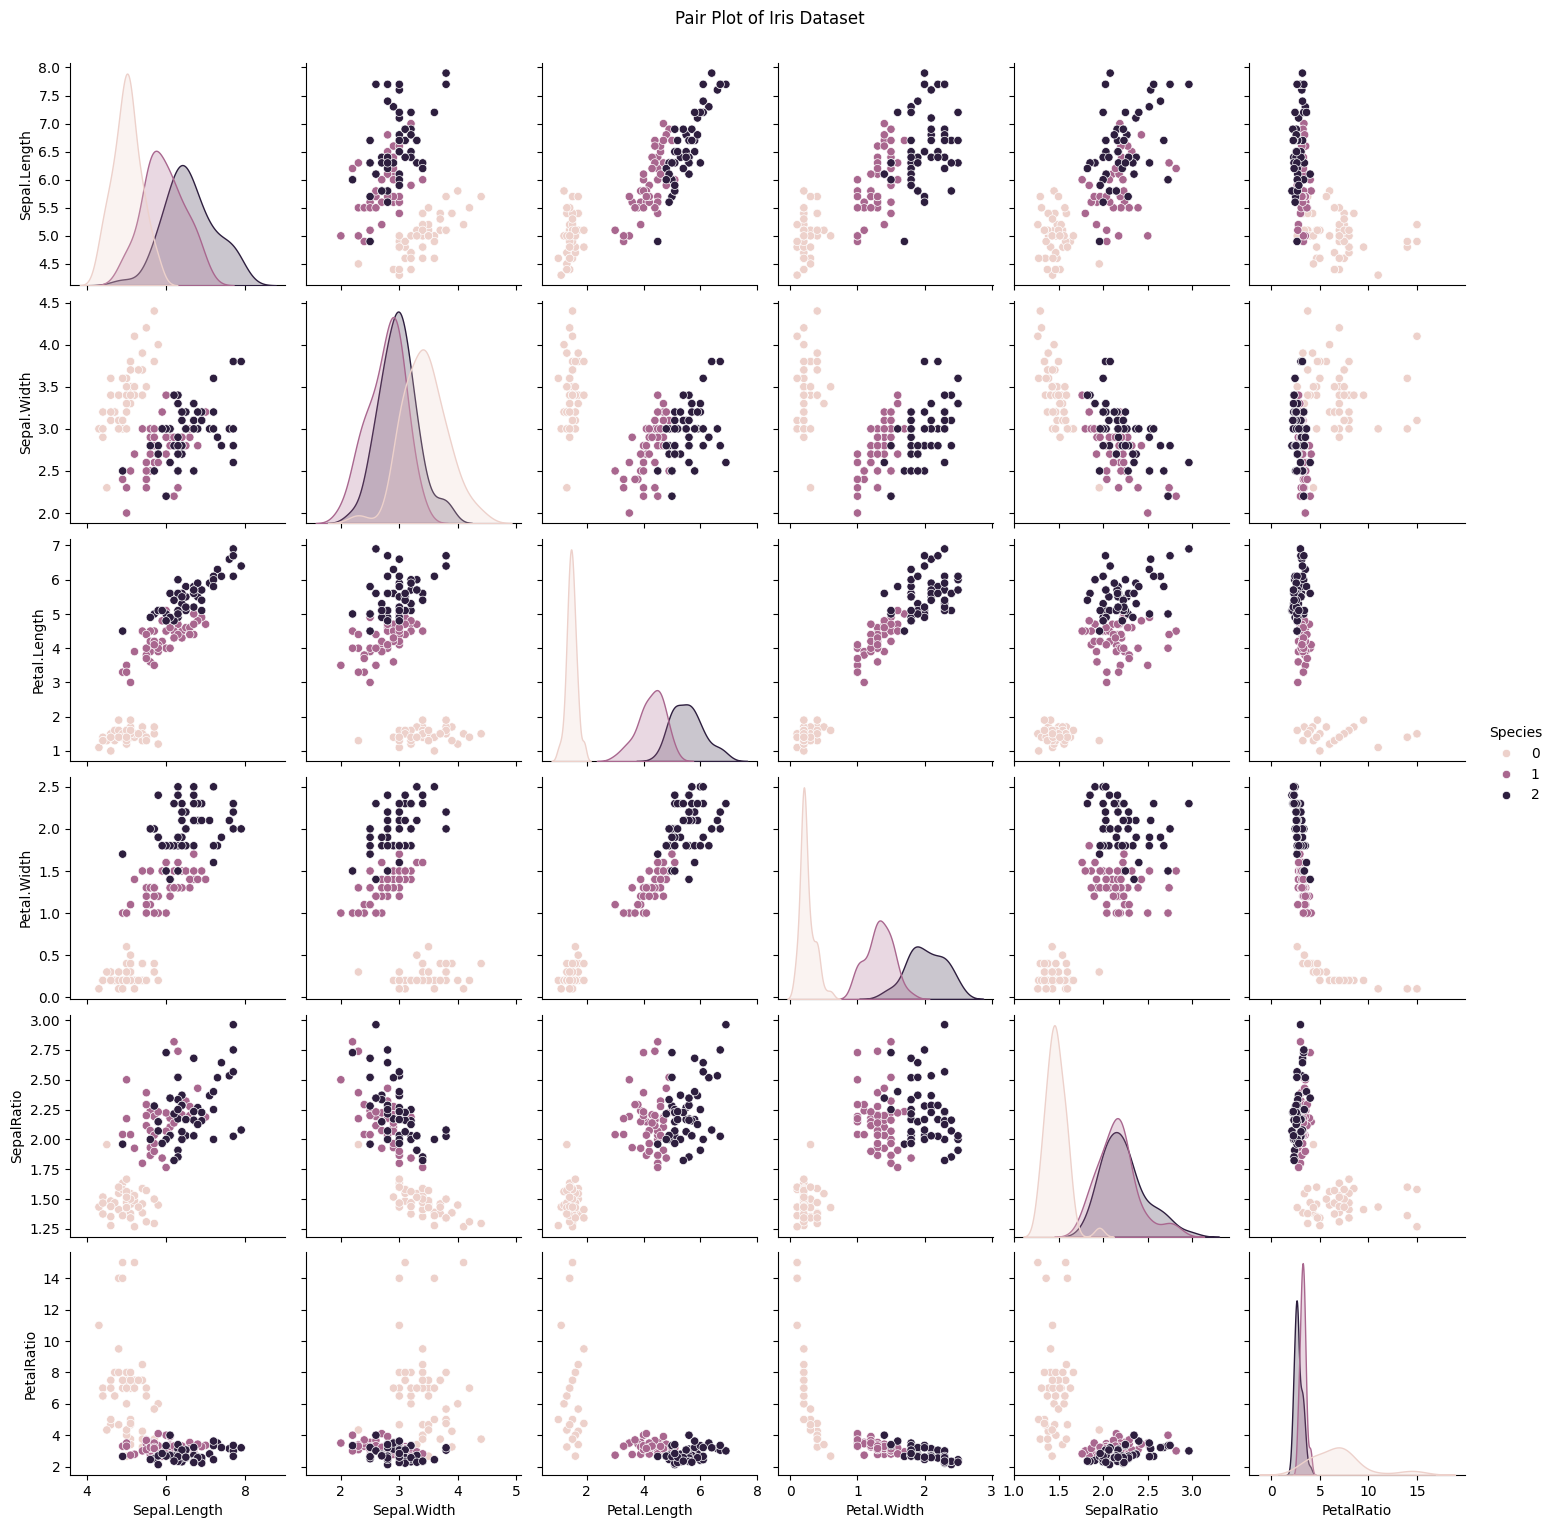

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import numpy as np

def load_and_analyze_iris(file_path):
    df = pd.read_csv(file_path)
    le = LabelEncoder()
    df['Species'] = le.fit_transform(df['Species'])
    
    print(f"Number of data points: {len(df)}")
    print(f"Data types of columns:\n{df.dtypes}")
    print(f"Column names: {df.columns.tolist()}")
    print(f"Number of flower species: {df['Species'].nunique()}")
    return df

def correct_iris_errors(df):
    df.loc[34] = [4.9, 3.1, 1.5, 0.2, 0]
    df.loc[37] = [4.9, 3.6, 1.4, 0.1, 0]
    print("\nCorrected Rows:")
    print(df.iloc[[34, 37]])
    return df

def add_features_and_save(df, output_file):
    df['PetalRatio'] = df['Petal.Length'] / df['Petal.Width']
    df['SepalRatio'] = df['Sepal.Length'] / df['Sepal.Width']
    df.to_csv(output_file, index=False)
    print(f"\nNew features added. Data saved to '{output_file}'.")

def calculate_correlations(df):
    numeric_df = df.select_dtypes(include=[np.number])
    correlations = numeric_df.corr()
    corr_unstacked = correlations.unstack().sort_values(ascending=False)
    highest_positive = corr_unstacked[corr_unstacked < 1].idxmax()
    highest_negative = corr_unstacked.idxmin()
    print("\nPairwise Correlations:")
    print(correlations)
    print(f"\nHighest positive correlation: {highest_positive} = {corr_unstacked[highest_positive]}")
    print(f"Highest negative correlation: {highest_negative} = {corr_unstacked[highest_negative]}")

def scatter_with_regression(df, output_file):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="SepalRatio", y="PetalRatio", hue="Species", palette="Set2")
    for species in df['Species'].unique():
        species_data = df[df['Species'] == species]
        X = species_data['SepalRatio'].values.reshape(-1, 1)
        y = species_data['PetalRatio'].values
        reg = LinearRegression().fit(X, y)
        plt.plot(X, reg.predict(X), label=f"Species {species} Regression", linestyle="--")
    plt.legend()
    plt.title("Sepal Ratio vs Petal Ratio with Regression Lines")
    plt.savefig(output_file)
    plt.close()
    print(f"\nScatter plot saved as '{output_file}'.")

def create_pair_plot(df):
    sns.pairplot(df, hue="Species", vars=["Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width", "SepalRatio", "PetalRatio"])
    plt.suptitle("Pair Plot of Iris Dataset", y=1.02)
    plt.show()

def main():
    iris_file = "iris.csv"
    corrected_file = "iris_corrected.csv"
    scatter_plot_file = "iris_scatter_with_regression.pdf"
    
    
    df = load_and_analyze_iris(iris_file)
    
    
    df = correct_iris_errors(df)
    
    
    add_features_and_save(df, corrected_file)
    
    
    calculate_correlations(df)
    
    
    scatter_with_regression(df, scatter_plot_file)
    
    
    create_pair_plot(df)

if __name__ == "__main__":
    main()
